In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

print("Done!")
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Done!


# Setup and Imports

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from pathlib import Path
import shutil
from datetime import datetime

print("🚀 ASL Training on Kaggle")
print("=" * 50)
print(f"TensorFlow Version: {tf.__version__}")

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU Available: {len(gpus)} GPU(s)")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("✅ Mixed precision enabled")
    HAS_GPU = True
else:
    print("❌ No GPU detected")
    HAS_GPU = False

print("=" * 50)

2025-10-01 00:10:47.733381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759277447.922199      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759277447.976004      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🚀 ASL Training on Kaggle
TensorFlow Version: 2.18.0
✅ GPU Available: 1 GPU(s)
✅ Mixed precision enabled


# Find Dataset

In [3]:
# Find dataset path
input_dir = Path('/kaggle/input/asl-alphabet')
dataset_path = None

if input_dir.exists():
    print("🔍 Searching for dataset...")
    for item in input_dir.iterdir():
        print(f"   Found: {item}")
        
        # Look for asl_alphabet_train folder (might be nested)
        possible_paths = [
            item / 'asl_alphabet_train',  # Direct path
            item,  # Root might be the dataset itself
        ]
        
        for path in possible_paths:
            if path.exists() and path.is_dir():
                # Check if this directory contains letter folders (A, B, C, etc.)
                subdirs = [d for d in path.iterdir() if d.is_dir()]
                letter_dirs = [d for d in subdirs if d.name in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ' or d.name in ['space', 'del', 'nothing']]
                
                if len(letter_dirs) > 10:  # Should have at least 10 letter folders
                    dataset_path = str(path)
                    print(f"✅ Dataset found with {len(letter_dirs)} letter folders: {dataset_path}")
                    break
        
        if dataset_path:
            break

if not dataset_path:
    print("❌ Dataset not found!")
    print("Expected structure: dataset/A/, dataset/B/, dataset/C/, etc.")
else:
    print(f"📁 Using dataset: {dataset_path}")
    
    # Debug: Show what's actually in the dataset
    dataset_check = Path(dataset_path)
    print(f"\n🔍 Dataset contents:")
    for item in sorted(dataset_check.iterdir()):
        if item.is_dir():
            count = len(list(item.glob('*.jpg')) + list(item.glob('*.png')))
            print(f"  📁 {item.name}: {count} images")
        else:
            print(f"  📄 {item.name}")

🔍 Searching for dataset...
   Found: /kaggle/input/asl-alphabet/asl_alphabet_test
   Found: /kaggle/input/asl-alphabet/asl_alphabet_train
✅ Dataset found with 29 letter folders: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train
📁 Using dataset: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train

🔍 Dataset contents:
  📁 A: 3000 images
  📁 B: 3000 images
  📁 C: 3000 images
  📁 D: 3000 images
  📁 E: 3000 images
  📁 F: 3000 images
  📁 G: 3000 images
  📁 H: 3000 images
  📁 I: 3000 images
  📁 J: 3000 images
  📁 K: 3000 images
  📁 L: 3000 images
  📁 M: 3000 images
  📁 N: 3000 images
  📁 O: 3000 images
  📁 P: 3000 images
  📁 Q: 3000 images
  📁 R: 3000 images
  📁 S: 3000 images
  📁 T: 3000 images
  📁 U: 3000 images
  📁 V: 3000 images
  📁 W: 3000 images
  📁 X: 3000 images
  📁 Y: 3000 images
  📁 Z: 3000 images
  📁 del: 3000 images
  📁 nothing: 3000 images
  📁 space: 3000 images


# Prepare dataset

In [4]:
def prepare_dataset(input_dir, output_dir):
    print(f"📁 Preparing dataset from: {input_dir}")
    
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Get all class directories - filter for actual letter/word folders
    all_dirs = [d for d in input_path.iterdir() if d.is_dir()]
    
    # Filter for valid ASL classes (letters + special classes)
    valid_classes = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ') | {'space', 'del', 'nothing'}
    class_dirs = [d for d in all_dirs if d.name in valid_classes or len(d.name) == 1]
    
    print(f"Found {len(all_dirs)} total directories, {len(class_dirs)} valid classes")
    print(f"Valid classes: {sorted([d.name for d in class_dirs])}")
    
    if len(class_dirs) == 0:
        print("❌ No valid ASL class folders found!")
        print("Expected folders: A, B, C, ..., Z, space, del, nothing")
        print("Available folders:", [d.name for d in all_dirs])
        return None
    
    splits = ['train', 'val', 'test']
    split_ratios = [0.7, 0.15, 0.15]
    
    for split in splits:
        (output_path / split).mkdir(exist_ok=True)
    
    total_files = 0
    split_counts = {'train': 0, 'val': 0, 'test': 0}
    
    for class_dir in class_dirs:
        print(f"Processing: {class_dir.name}")
        
        image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png')) + list(class_dir.glob('*.jpeg'))
        image_files.sort()
        
        if len(image_files) == 0:
            print(f"  ⚠️  No images found in {class_dir.name}")
            continue
        
        print(f"  Found {len(image_files)} images")
        total_files += len(image_files)
        
        n_files = len(image_files)
        train_end = int(n_files * split_ratios[0])
        val_end = train_end + int(n_files * split_ratios[1])
        
        for split in splits:
            (output_path / split / class_dir.name).mkdir(exist_ok=True)
        
        for i, img_file in enumerate(image_files):
            if i < train_end:
                split = 'train'
            elif i < val_end:
                split = 'val'
            else:
                split = 'test'
            
            dst = output_path / split / class_dir.name / img_file.name
            shutil.copy2(img_file, dst)
            split_counts[split] += 1
    
    print(f"✅ Dataset prepared: {total_files:,} total files")
    print(f"   Train: {split_counts['train']:,}")
    print(f"   Val: {split_counts['val']:,}")
    print(f"   Test: {split_counts['test']:,}")
    return str(output_path)

# Prepare the dataset - IMPORTANT: Output must be in /kaggle/working/ (writable)
prepared_dataset = prepare_dataset(dataset_path, '/kaggle/working/dataset')

📁 Preparing dataset from: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train
Found 29 total directories, 29 valid classes
Valid classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Processing: N
  Found 3000 images
Processing: R
  Found 3000 images
Processing: space
  Found 3000 images
Processing: B
  Found 3000 images
Processing: I
  Found 3000 images
Processing: del
  Found 3000 images
Processing: F
  Found 3000 images
Processing: H
  Found 3000 images
Processing: E
  Found 3000 images
Processing: U
  Found 3000 images
Processing: M
  Found 3000 images
Processing: X
  Found 3000 images
Processing: K
  Found 3000 images
Processing: Q
  Found 3000 images
Processing: Y
  Found 3000 images
Processing: S
  Found 3000 images
Processing: G
  Found 3000 images
Processing: A
  Found 3000 images
Processing: O
  Found 3000 images
Processing: T
  Found 3000 images
Proce

# Create Dataset Loaders

In [5]:
def create_dataset(data_dir, batch_size=32, img_size=(200, 200)):
    dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='categorical'
    )
    return dataset, dataset.class_names

def augment_dataset(dataset, is_training=True):
    data_augmentation = tf.keras.Sequential([
        layers.Rescaling(1./255),
    ])
    
    if is_training:
        data_augmentation.add(layers.RandomRotation(0.1))
        data_augmentation.add(layers.RandomZoom(0.1))
        data_augmentation.add(layers.RandomContrast(0.2))
        data_augmentation.add(layers.RandomBrightness(0.2))
    
    dataset = dataset.map(
        lambda x, y: (data_augmentation(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    return dataset.prefetch(tf.data.AUTOTUNE)

# Set parameters
BATCH_SIZE = 64 if HAS_GPU else 32
IMG_SIZE = (200, 200)
OUTPUT_DIR = '/kaggle/working/models'

print(f"Batch size: {BATCH_SIZE}")
print(f"Image size: {IMG_SIZE}")

# Load datasets
train_ds, class_names = create_dataset(f"{prepared_dataset}/train", BATCH_SIZE, IMG_SIZE)
val_ds, _ = create_dataset(f"{prepared_dataset}/val", BATCH_SIZE, IMG_SIZE)
test_ds, _ = create_dataset(f"{prepared_dataset}/test", BATCH_SIZE, IMG_SIZE)

print(f"✅ Loaded {len(class_names)} classes: {class_names}")

# Apply augmentation
train_ds = augment_dataset(train_ds, True)
val_ds = augment_dataset(val_ds, False)
test_ds = augment_dataset(test_ds, False)

print("✅ Data augmentation applied")

Batch size: 64
Image size: (200, 200)
Found 60900 files belonging to 29 classes.


I0000 00:00:1759277767.177775      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 13050 files belonging to 29 classes.
Found 13050 files belonging to 29 classes.
✅ Loaded 29 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
✅ Data augmentation applied


# Create Model

In [6]:
def create_model(num_classes, img_size=(200, 200)):
    base_model = MobileNetV3Large(
        input_shape=(*img_size, 3),
        alpha=1.0,
        minimalistic=False,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    
    base_model.trainable = False
    
    inputs = keras.Input(shape=(*img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    return model, base_model

# Calculate class weights
def calculate_class_weights(dataset, class_names):
    class_counts = np.zeros(len(class_names))
    total_samples = 0
    
    for images, labels in dataset:
        label_indices = tf.argmax(labels, axis=1)
        for idx in label_indices:
            class_counts[idx.numpy()] += 1
        total_samples += len(labels)
    
    class_weights = {}
    for i, count in enumerate(class_counts):
        if count > 0:
            class_weights[i] = total_samples / (len(class_names) * count)
        else:
            class_weights[i] = 1.0
    
    return class_weights

# Create model and calculate weights
model, base_model = create_model(len(class_names), IMG_SIZE)
class_weights = calculate_class_weights(train_ds, class_names)

print(f"✅ Model created with {model.count_params():,} parameters")
print(f"✅ Class weights calculated")

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Model created with 3,024,221 parameters
✅ Class weights calculated


# Train Model - Phase 1

In [7]:
# Setup output directory
output_path = Path(OUTPUT_DIR)
output_path.mkdir(parents=True, exist_ok=True)

print("🎯 Phase 1: Training classifier head")

# Phase 1 callbacks
callbacks_phase1 = [
    ModelCheckpoint(
        str(output_path / 'best_model_phase1.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

# Train phase 1 (15 epochs)
history_phase1 = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks_phase1,
    verbose=1
)

print("✅ Phase 1 completed")

🎯 Phase 1: Training classifier head
Epoch 1/15


I0000 00:00:1759278110.028500      66 service.cc:148] XLA service 0x7c9a00003070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759278110.031702      66 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759278112.733951      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/952 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.0358 - loss: 3.6143

I0000 00:00:1759278119.464953      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


952/952 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.0360 - loss: 3.4154
Epoch 1: val_accuracy improved from -inf to 0.03448, saving model to /kaggle/working/models/best_model_phase1.keras
952/952 ━━━━━━━━━━━━━━━━━━━━ 352s 349ms/step - accuracy: 0.0360 - loss: 3.4154 - val_accuracy: 0.0345 - val_loss: 3.3611
Epoch 2/15
951/952 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.0409 - loss: 3.3780
Epoch 2: val_accuracy improved from 0.03448 to 0.07402, saving model to /kaggle/working/models/best_model_phase1.keras
952/952 ━━━━━━━━━━━━━━━━━━━━ 324s 339ms/step - accuracy: 0.0409 - loss: 3.3780 - val_accuracy: 0.0740 - val_loss: 3.3378
Epoch 3/15
952/952 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.0428 - loss: 3.3696
Epoch 3: val_accuracy did not improve from 0.07402
952/952 ━━━━━━━━━━━━━━━━━━━━ 324s 339ms/step - accuracy: 0.0428 - loss: 3.3696 - val_accuracy: 0.0570 - val_loss: 3.3242
Epoch 4/15
951/952 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.0461 - loss: 3.3651
Epoch 4: v

# Train Model - Phase 2

In [8]:
print("🔥 Phase 2: Fine-tuning entire model")

# Unfreeze base model
base_model.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00002),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Phase 2 callbacks
callbacks_phase2 = [
    ModelCheckpoint(
        str(output_path / 'best_model_final.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.000001,
        verbose=1
    )
]

# Train phase 2 (15 more epochs) - FIXED with proper epoch counting
try:
    print("Starting Phase 2 training...")
    history_phase2 = model.fit(
        train_ds,
        epochs=30,  # Total epochs (15 + 15)
        validation_data=val_ds,
        class_weight=class_weights,
        callbacks=callbacks_phase2,
        verbose=1,
        initial_epoch=15  # Start from epoch 15, train to epoch 30
    )
    print("✅ Phase 2 completed successfully")
    
    # Check if training actually happened
    if len(history_phase2.history) == 0 or len(history_phase2.history.get('loss', [])) == 0:
        print("⚠️  Phase 2 didn't train any epochs (check epoch settings)")
        raise ValueError("No epochs trained in Phase 2")
        
except Exception as e:
    print(f"⚠️  Phase 2 training failed: {e}")
    print("Creating empty history for phase 2...")
    # Create empty history object
    class EmptyHistory:
        def __init__(self):
            self.history = {}
    history_phase2 = EmptyHistory()

# Combine histories - Fix for empty Phase 2 history
combined_history = {}

# Debug: Print available keys
print("Phase 1 history keys:", list(history_phase1.history.keys()))
print("Phase 2 history keys:", list(history_phase2.history.keys()))

# Check if Phase 2 training actually happened
if len(history_phase2.history) == 0:
    print("⚠️  Phase 2 training failed - using only Phase 1 history")
    combined_history = history_phase1.history.copy()
else:
    # Normal case - combine both phases
    common_keys = set(history_phase1.history.keys()) & set(history_phase2.history.keys())
    print(f"Common keys: {common_keys}")

    for key in common_keys:
        combined_history[key] = history_phase1.history[key] + history_phase2.history[key]

    # Add any missing keys from phase 1
    for key in history_phase1.history.keys():
        if key not in combined_history:
            if 'loss' in history_phase2.history:
                combined_history[key] = history_phase1.history[key] + [None] * len(history_phase2.history['loss'])
            else:
                combined_history[key] = history_phase1.history[key]
            print(f"⚠️  Added {key} from phase 1 only")

print("✅ Training completed!")

🔥 Phase 2: Fine-tuning entire model
Starting Phase 2 training...
Epoch 16/30
952/952 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.0397 - loss: 8.0186
Epoch 16: val_accuracy improved from -inf to 0.03456, saving model to /kaggle/working/models/best_model_final.keras
952/952 ━━━━━━━━━━━━━━━━━━━━ 453s 391ms/step - accuracy: 0.0397 - loss: 8.0157 - val_accuracy: 0.0346 - val_loss: 4.9817 - learning_rate: 2.0000e-05
Epoch 17/30
952/952 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.1046 - loss: 3.1419
Epoch 17: val_accuracy improved from 0.03456 to 0.07678, saving model to /kaggle/working/models/best_model_final.keras
952/952 ━━━━━━━━━━━━━━━━━━━━ 334s 350ms/step - accuracy: 0.1046 - loss: 3.1418 - val_accuracy: 0.0768 - val_loss: 3.7979 - learning_rate: 2.0000e-05
Epoch 18/30
951/952 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.2601 - loss: 2.5200
Epoch 18: val_accuracy improved from 0.07678 to 0.27088, saving model to /kaggle/working/models/best_model_final.keras
952/952 ━━━━━━━━

# Evaluate and Export

In [9]:
# Evaluate on test set
print("📊 Evaluating model...")

predictions = []
true_labels = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    predictions.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

test_accuracy = np.mean(np.array(predictions) == np.array(true_labels))
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# Export models
print("📦 Exporting models...")

# Save Keras model
try:
    model.save(output_path / 'model.keras')
    print("✅ Keras model saved")
except Exception as e:
    print(f"❌ Keras model save failed: {e}")

# Save labels
try:
    with open(output_path / 'training_set_labels.txt', 'w') as f:
        for label in class_names:
            f.write(f"{label}\n")
    print("✅ Labels saved")
except Exception as e:
    print(f"❌ Labels save failed: {e}")

# Convert to TFLite with error handling
print("🔄 Converting to TensorFlow Lite...")
try:
    # Create a representative dataset for quantization (optional but recommended)
    def representative_data_gen():
        count = 0
        for images, _ in train_ds.take(100):  # Use 100 batches
            for i in range(min(5, images.shape[0])):  # Take up to 5 images per batch
                if count >= 100:  # Limit to 100 samples total
                    return
                yield [tf.cast(images[i:i+1], tf.float32)]
                count += 1

    # Basic TFLite conversion
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Try with representative dataset for better optimization
    try:
        converter.representative_dataset = representative_data_gen
        print("  Using representative dataset for optimization...")
    except:
        print("  Using basic optimization...")

    # Set supported ops to avoid conversion issues
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS  # Fallback for unsupported ops
    ]

    # Convert with timeout handling
    print("  Converting model (this may take a few minutes)...")
    tflite_model = converter.convert()

    # Save TFLite model
    tflite_path = output_path / 'model.tflite'
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

    tflite_size = len(tflite_model) / (1024 * 1024)
    print(f"✅ TensorFlow Lite model saved ({tflite_size:.1f} MB)")

except Exception as e:
    print(f"⚠️  TFLite conversion failed: {e}")
    print("   Continuing without TFLite model...")

# Save training history
try:
    # Convert numpy arrays to lists for JSON serialization
    history_for_json = {}
    for key, values in combined_history.items():
        if isinstance(values, list):
            # Convert any numpy values to Python floats
            history_for_json[key] = [float(v) if v is not None else None for v in values]
        else:
            history_for_json[key] = values

    with open(output_path / 'training_history.json', 'w') as f:
        json.dump(history_for_json, f, indent=2)
    print("✅ Training history saved")
except Exception as e:
    print(f"⚠️  Training history save failed: {e}")

# Create a simple metadata file
try:
    metadata = {
        'model_info': {
            'test_accuracy': float(test_accuracy),
            'num_classes': len(class_names),
            'class_names': class_names,
            'input_shape': [200, 200, 3],
            'model_type': 'MobileNetV3Large',
            'training_date': datetime.now().isoformat()
        }
    }

    with open(output_path / 'model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    print("✅ Model metadata saved")
except Exception as e:
    print(f"⚠️  Metadata save failed: {e}")

print("✅ Export process completed!")

# Final summary
print("\n" + "=" * 60)
print("🎉 TRAINING COMPLETED!")
print(f"📊 Test Accuracy: {test_accuracy:.4f}")
print(f"📁 Models saved to: {OUTPUT_DIR}")

# List all generated files
print("\n📁 Generated files:")
try:
    for file in sorted(output_path.rglob('*')):
        if file.is_file():
            size_mb = file.stat().st_size / (1024*1024)
            print(f"   📄 {file.name}: {size_mb:.1f} MB")
except Exception as e:
    print(f"Error listing files: {e}")

print("=" * 60)

📊 Evaluating model...
✅ Test Accuracy: 0.9583
📦 Exporting models...
✅ Keras model saved
✅ Labels saved
🔄 Converting to TensorFlow Lite...
  Using representative dataset for optimization...
  Converting model (this may take a few minutes)...
Saved artifact at '/tmp/tmpcfsjok2t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='keras_tensor_215')
Output Type:
  TensorSpec(shape=(None, 29), dtype=tf.float16, name=None)
Captures:
  137003945947984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137003792113040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137003792112464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137003792113616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137003792113808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137003792114576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137003792114960: TensorSpec(shape=(), dtype=tf.r

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1759287258.931704      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1759287258.931746      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1759287259.067722      19 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
INFO: Created TensorFlow Lite delegate for select TF ops.
I0000 00:00:1759287261.230354      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
INFO: TfLiteFlexDelegate delegate: 228 nodes delegated out of 440 nodes with 56 partitions.

fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


✅ TensorFlow Lite model saved (3.0 MB)
✅ Training history saved
✅ Model metadata saved
✅ Export process completed!

🎉 TRAINING COMPLETED!
📊 Test Accuracy: 0.9583
📁 Models saved to: /kaggle/working/models

📁 Generated files:
   📄 best_model_final.keras: 58.2 MB
   📄 best_model_phase1.keras: 12.6 MB
   📄 model.keras: 58.2 MB
   📄 model.tflite: 3.0 MB
   📄 model_metadata.json: 0.0 MB
   📄 training_history.json: 0.0 MB
   📄 training_set_labels.txt: 0.0 MB


# Plot Results

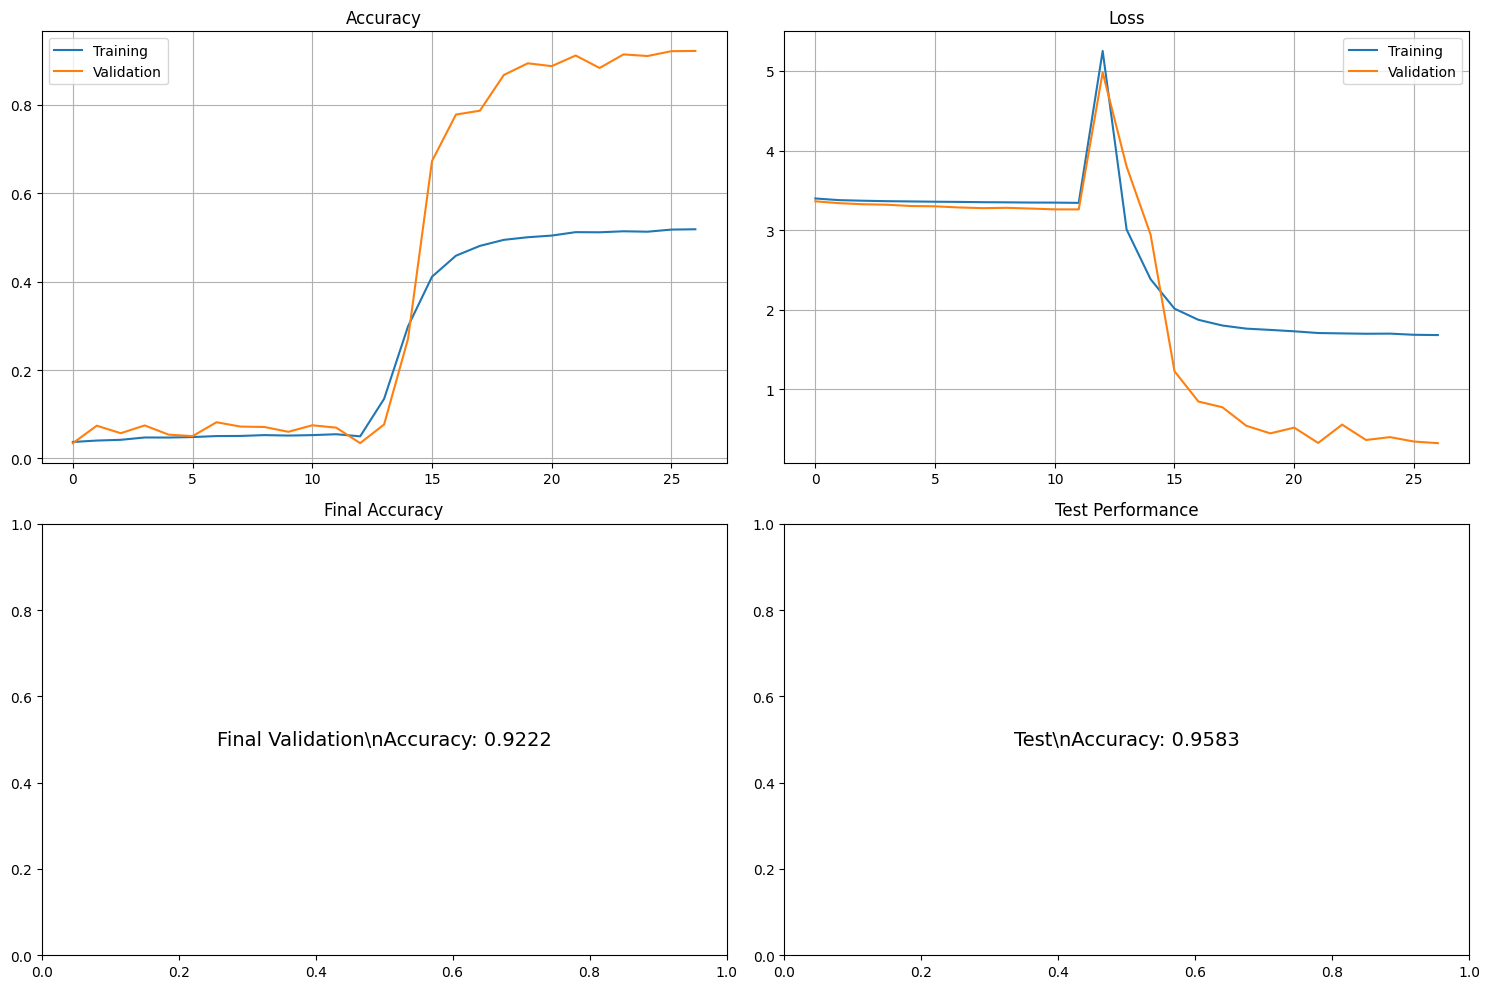

📁 Generated files:
   best_model_final.keras: 58.2 MB
   model_metadata.json: 0.0 MB
   training_history.json: 0.0 MB
   training_results.png: 0.3 MB
   model.keras: 58.2 MB
   model.tflite: 3.0 MB
   best_model_phase1.keras: 12.6 MB
   training_set_labels.txt: 0.0 MB


In [10]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0,0].plot(combined_history['accuracy'], label='Training')
axes[0,0].plot(combined_history['val_accuracy'], label='Validation')
axes[0,0].set_title('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True)

# Loss
axes[0,1].plot(combined_history['loss'], label='Training')
axes[0,1].plot(combined_history['val_loss'], label='Validation')
axes[0,1].set_title('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

# Final metrics
final_acc = combined_history['val_accuracy'][-1]
final_loss = combined_history['val_loss'][-1]
axes[1,0].text(0.5, 0.5, f'Final Validation\\nAccuracy: {final_acc:.4f}',
               ha='center', va='center', transform=axes[1,0].transAxes, fontsize=14)
axes[1,0].set_title('Final Accuracy')

axes[1,1].text(0.5, 0.5, f'Test\\nAccuracy: {test_accuracy:.4f}',
               ha='center', va='center', transform=axes[1,1].transAxes, fontsize=14)
axes[1,1].set_title('Test Performance')

plt.tight_layout()
plt.savefig(output_path / 'training_results.png', dpi=300, bbox_inches='tight')
plt.show()

# List generated files
print("📁 Generated files:")
for file in output_path.rglob('*'):
    if file.is_file():
        size_mb = file.stat().st_size / (1024*1024)
        print(f"   {file.name}: {size_mb:.1f} MB")